# Carga de Librerias

Librerías base y path actual

In [40]:
import os
print(os.getcwd())

C:\Users\mauricio\Desktop\PruebaTecnicaWandJ


Librerías de terceros

In [314]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt

import nltk
#nltk.download('punkt') # descargar punkt para poder usar el word tokenizer
#nltk.download('stopwords') # descargar stopwords en multiples idiomas
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, classification_report

Banderas de procesamiento

In [305]:
create_ETL_data = False

# ETL

In [146]:
df_org = pd.read_json('Data/News_Category_Dataset_v2.json',lines=True)
# Rename index as id since it will help to build the data after token explode
df_org.index.rename('id',inplace= True)
df_org

,category,headline,authors,link,short_description,date
id,,,,,,
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28


In [147]:
alt.Chart(df_org['category']
              .value_counts()
              .reset_index()
              .rename(columns={'category':'freq',
                               'index':'category'})
).mark_bar().encode(
    y='freq:Q',
    x=alt.X('category:N', sort='-y'),
    tooltip=['category','freq']
).properties(
    title='[Interactive] Articles by Category'
)

alt.Chart(...)

Ahora veamos la suma porcentual acumulada de las categorías para entender en que categorías se tendría el mayor impacto si se hace bien.

In [148]:
(df_org[["category", "headline"]].category.value_counts().cumsum()/200853).head(10)

POLITICS          0.163000
WELLNESS          0.251756
ENTERTAINMENT     0.331705
TRAVEL            0.380930
STYLE & BEAUTY    0.428970
PARENTING         0.472171
HEALTHY LIVING    0.505499
QUEER VOICES      0.536935
FOOD & DRINK      0.567933
BUSINESS          0.597492
Name: category, dtype: float64

Las 7 primeras categorias abarcan más del 50 porciento de los datos. Sin embargo, luego de la categoría 7, empiezan a aparecer categorias que parecieran estar duplicadas, como por ejemplo "PARENTING" Y "PARENTS" o "THE WORDPOST" Y "WORLDPOST", "ARTS" "ARTS AND CULTURE" Y "CULTURE ARTS, "EDUCATION" Y "COLLEGE", "STYLE AND BEAUTY" Y "STYLE". Es posible que se tenga una sutil diferencia entre estas categorias.

## Muestrear los datos

Hagamos más adsequible el computo con el 30% de los datos

In [243]:
df = df_org.sample(frac = 0.1, random_state=1)

## Tokenization, Stopwords y Stemming 

In [260]:
def tokenization_stopwords_stemming(df, col_name='headline', tok_col_name='tok'):
    """
    Function that, given a pandas dataframe, a text column name and token column name,
    applies tokenization, stopwords(english) and stemming(english).
    Returns dataframe with column tok_col_name added
    """
    # Tokenization
    df[tok_col_name] = df[col_name].apply(word_tokenize)
    df_tok = df.explode(tok_col_name)
    
    # Convert tokens to lower case
    df_tok.loc[:,[tok_col_name]] = df_tok.apply(lambda x: str(x[tok_col_name]).lower(), axis = 1)
    
    # Get stopwords
    stop_words = [x for x in nltk.corpus.stopwords.words('english')]
    # Add some custom punctation (some punctation could be usefull)
    stop_words.extend(['-','(',')','.',':',',',"'","'s",'?',"n't","’","_"])
    
    # Clean stopwords and some punctuation
    df_tok.loc[:,['in_stopwords']] = df_tok.apply(lambda x: x[tok_col_name] in stop_words, axis = 1)
    df_tok_clean = df_tok[~df_tok['in_stopwords']]
    
    # Apply Snowball stemmer
    stemmer = nltk.stem.SnowballStemmer('english')
    df_tok_clean.loc[:,[tok_col_name]] = df_tok_clean[tok_col_name].astype(str)
    df_tok_clean.loc[:,[tok_col_name]] = df_tok_clean.apply(lambda x: stemmer.stem(x[tok_col_name]), axis = 1)
    
    return(df_tok_clean)
    

In [245]:
df_tok_clean = tokenization_stopwords_stemming(df)

c:\users\mauricio\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## Plot Palabras por Categoria

In [259]:
def plot_freq_x_context(df_tok_clean, class_col_name='category', tok_col_name='tok', n=5):
    """
    Function that, given a pandas dataframe, a text column name and token column name,
    plots the n largest frequency tokens by class_col_name.
    Returns altair chart
    """
    # Group tokens by class_col_name and tokname
    grouped_toks = (df_tok_clean
                        .reset_index()
                        .filter(['id',class_col_name,tok_col_name], axis=1)
                        .groupby([class_col_name,tok_col_name])
                        .agg({'id':['count']})
                        .sort_values([class_col_name,('id', 'count')], ascending = False)
    )
    grouped_toks.columns = grouped_toks.columns.map('_'.join)
    grouped_toks = grouped_toks.rename(columns = {'id_count':'count'}).reset_index()
    
    # Return altair facet graph
    return(alt.Chart(grouped_toks
                  .groupby(class_col_name)
                  .head(n)
    ).mark_bar().encode(
        x='count:Q',
        y=alt.Y(tok_col_name + ':N', sort='-x'),
        tooltip=[tok_col_name,'count']
    ).properties(
        width=120,
        height=50
    ).facet(
        facet= class_col_name + ':N',
        columns=4
    ).resolve_scale(
      x='independent',
      y='independent'
    ))
    
plot_freq_x_context(df_tok_clean)

alt.FacetChart(...)

Viendo las 5 palabras más comunes entre algunas categorias, refuerza la idea de poca diferenciación entre algunas categorias, como por ejemplo: "ARTS & CULTURE", "ARTS" y "CULTURE & ARTS" donde la palabra "art" y "artist" está entre las primeras palabras más frecuentes. Por otro lado, vemos que trum aparece en muchas categorias, sin embargo, en politics aparece tanto la palabra "donald" como la palabra "trump". Es posible que un acercameinto con bigramas, puede ser útil.

## Creación texto líquido 

In [258]:
def to_liquid_text(df_tok_clean, class_col_name='category', tok_col_name='tok'):
    """
    Function that, given a pandas dataframe, a class_col_name and tok_col_name,
    joins the column tok_col_name with a space for each "id" in order to form a liquid text column.
    Returns dataframe with column 'text' added
    """
    return(df_tok_clean
               .reset_index()
               .filter(['id',class_col_name,tok_col_name], axis=1)
               .groupby(['id',class_col_name])[tok_col_name]
               .apply(' '.join)
               .reset_index()
               .rename(columns = {tok_col_name:'text'}))

In [248]:
df_liquid_text = to_liquid_text(df_tok_clean)
df_liquid_text.head()

,id,category,text
0,24,WORLD NEWS,2 men deton bomb insid indian restaur near tor...
1,38,COMEDY,seth meyer 1 funni regret trump cancel north k...
2,53,ENTERTAINMENT,harvey weinstein accus say never thought would...
3,56,ENTERTAINMENT,boba fett get star war movi
4,62,POLITICS,member far-right proud boy menac twitter user ...


Estos ejemplos parecen mostrar que la ETL esta funcionando bien. El proceso más demorado fue la función "tokenization_stopwords_stemming" que demoró 38 segundos para 20k de registros.

## ETL a todos los datos

In [261]:
def ETL(df, col_name= 'headline', class_col_name='category', tok_col_name='tok'):
    # Primer paso: Tokenizacion, stopwords y stemming
    df_tok_clean = tokenization_stopwords_stemming(df, col_name=col_name, tok_col_name=tok_col_name)
    
    # Segundo paso: Crear texto liquido del dataframe limpio
    df_liquid_text = to_liquid_text(df_tok_clean, class_col_name=class_col_name, tok_col_name=tok_col_name)
    
    return df_tok_clean,df_liquid_text

Apliquemos la ETL sobre todos los datos usando el campo al campo "headline".

In [266]:
if create_ETL_data: 
    df_tok_clean_headlines,df_liquid_text_headlines = ETL(df_org)
    df_tok_clean_headlines.to_pickle('./Data/clean_data_headlines.pkl')
    df_liquid_text_headlines.to_pickle('./Data/clean_liquidtext_headlines.pkl')

Ahora hagamos lo mismo a la combinación de "headline"+"short_description"

In [304]:
if create_ETL_data: 
    df_hd = df_org
    df_hd['headline_description'] = df_hd['headline'] + ' ' + df_hd['short_description']
    df_clean_headline_short_description,df_liquid_text_headline_short_description = ETL(df_hd, col_name='headline_description')
    df_clean_headline_short_description.to_pickle('./Data/clean_data_headline_short_description.pkl')
    df_liquid_text_headline_short_description.to_pickle('./Data/clean_liquidtext_headline_short_description.pkl')

c:\users\mauricio\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Modelos

## Solo Headlines NB

In [273]:
df_liquid_text = pd.read_pickle('./Data/clean_liquidtext_headlines.pkl')

Separemos una porción de los datos para hacer el entrenamiento y una porción para hacer el test

In [275]:
train, test = train_test_split(df_liquid_text, test_size=0.1, random_state=42, shuffle=True)
print(train.shape)
print(test.shape)

(180726, 3)
(20081, 3)


In [276]:
text_clf_CV = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
                    ])
param_grid = {
    'vect__max_features': [500,1000,5000,10000],
    'tfidf__use_idf': (True, False)
}

In [365]:
search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.675):
{'tfidf__use_idf': True, 'vect__max_features': 10000}


In [368]:
def GridSearchResultToDF(search):
    """
    Function that extracts the results from GridSearchCV and
    converts them to a pandas dataframe
    """
    return(pd.concat([pd.DataFrame(data = search.cv_results_['params']),
                      pd.DataFrame(data = {'mean': search.cv_results_['mean_test_score'],
                                           'std': search.cv_results_['std_test_score']})],
                     axis = 1))

def PlotComparison(result_values, descrete, continuous):
    """
    Function that takes the result from GridSearchResultToDF function and
    plots some of their values
    """
    base = alt.Chart(result_values).transform_calculate(
        ymin="datum.mean-2*datum.std",
        ymax="datum.mean+2*datum.std"
    )
    points = base.mark_point(
        filled=True,
        size=10
    ).encode(
        x=continuous,
        y=alt.Y('mean:Q', scale=alt.Scale(domain=(0.55, 0.7))),
        color=descrete,
        tooltip=['mean','std']
    )

    errorbars = base.mark_errorbar().encode(
        x=continuous,
        y="ymin:Q",
        y2="ymax:Q",
        color=descrete,
    )

    return(points + errorbars)

descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)
PlotComparison(result_values, descrete, continuous)

alt.LayerChart(...)

In [282]:
result_values.groupby(['tfidf__use_idf'])['mean'].agg(['mean'])

,mean
tfidf__use_idf,
False,0.446408
True,0.448264


La diferencia entre usar o no usar tfidf es mínima ya que parece que la mayoría de titulos son de dimensiones muy parecidas.

In [283]:
text_clf = search.best_estimator_.fit(train['text'], train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

0.5068970668791395

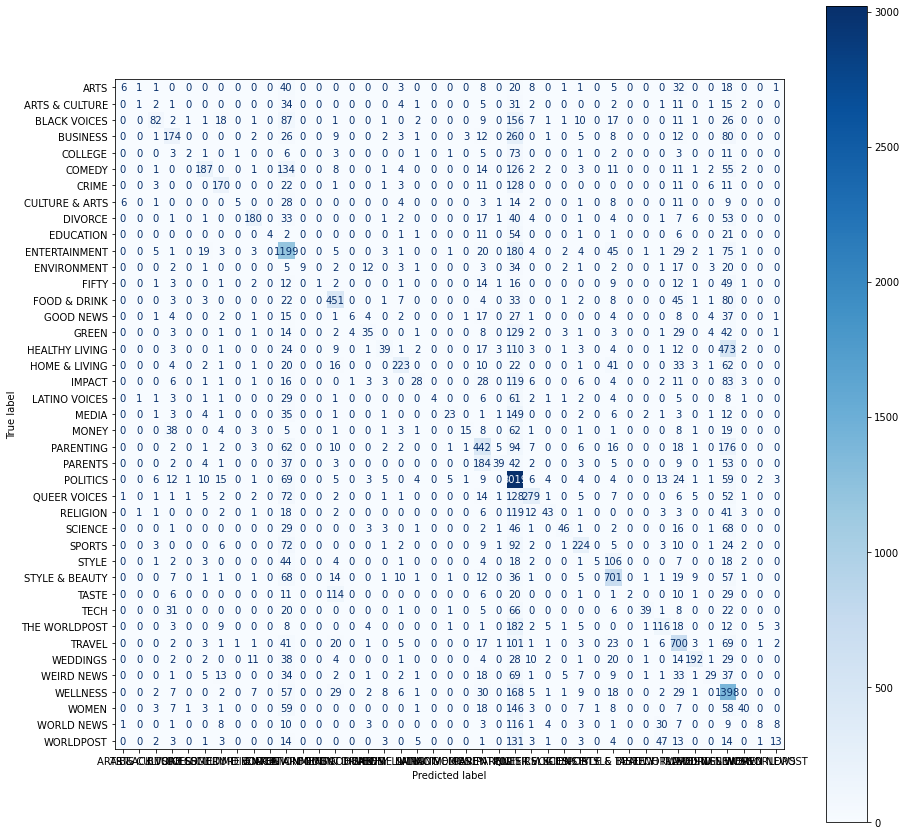

In [284]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)

Viendo la matriz de confusión podemos apreciar cuales son las confusiones más comunes. 

- Por un lado, las 3 categorías más comunes se tienen gran confusión con el resto de las categorias.
- "STYLE & BEAUTY" las confunde con "STYLE"
- "FOOD & DRINKS" son confundidas con "TASTE"
- "POLITICS" se confunde mucho con "BUSSINESS", "THE WORLDPOST", "ENTERTAIMENT"


Miremos ejemplos de las equivocaciones para hacernos una idea de la data. Empecemos por el caso donde realmente es un articulo de "BUSINESS" y se catalogó como "POLITICS"

In [285]:
classes = np.sort(df_org.category.unique())
test_probabilities = pd.DataFrame(data = text_clf.predict_proba(test['text']),
                                 index = test['id'],
                                 columns =  classes)
test['predicted'] = predicted_test
test_cols = test.columns
test_merge = test.merge(test_probabilities,'left',on = 'id')
test_case = test_merge[(test_merge['category'] == 'BUSINESS') & (test_merge['predicted'] == 'POLITICS')]
result = test_case[['id','category','text','predicted','POLITICS','BUSINESS']].sort_values('BUSINESS', ascending=False).head()
result

c:\users\mauricio\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,id,category,text,predicted,POLITICS,BUSINESS
5667,62215,BUSINESS,imf boss urg u.s. rais feder minimum wage,POLITICS,0.485013,0.352070
19016,180673,BUSINESS,bain capit among privat equiti firm probe tax ...,POLITICS,0.377901,0.349399
12368,173477,BUSINESS,bp plan $ 5.9 billion share buy back crimin fi...,POLITICS,0.372325,0.346403
18174,63227,BUSINESS,wall street journal vow fix pay gap women minor,POLITICS,0.356681,0.326940
16198,46341,BUSINESS,big bank say use scheme led well fargo fraud,POLITICS,0.323404,0.316098


In [287]:
df_org[df_org.index==62215][['headline','short_description']].values

array([['IMF Boss Urges U.S. To Raise The Federal Minimum Wage',
        'Christine Lagarde reckons that higher minimum wages and more family-friendly policies would improve the economy.']],
      dtype=object)

In [288]:
print(classification_report(test.category, predicted_test))

                precision    recall  f1-score   support

          ARTS       0.43      0.04      0.08       145
ARTS & CULTURE       0.25      0.01      0.02       113
  BLACK VOICES       0.69      0.19      0.30       435
      BUSINESS       0.51      0.29      0.37       599
       COLLEGE       0.33      0.02      0.03       113
        COMEDY       0.72      0.33      0.45       565
         CRIME       0.63      0.46      0.53       367
CULTURE & ARTS       0.71      0.05      0.10        93
       DIVORCE       0.81      0.51      0.63       352
     EDUCATION       1.00      0.04      0.08       102
 ENTERTAINMENT       0.47      0.75      0.57      1605
   ENVIRONMENT       1.00      0.08      0.14       118
         FIFTY       1.00      0.01      0.02       126
  FOOD & DRINK       0.62      0.68      0.65       662
     GOOD NEWS       0.55      0.04      0.08       136
         GREEN       0.49      0.12      0.20       284
HEALTHY LIVING       0.50      0.06      0.10  

## Headlines y Description NB

In [352]:
df_liquid_text2 = pd.read_pickle('./Data/clean_liquidtext_headline_short_description.pkl')
df_liquid_text2

,id,category,text
0,0,CRIME,2 mass shoot texa last week 1 tv left husband ...
1,1,ENTERTAINMENT,smith join diplo nicki jam 2018 world cup offi...
2,2,ENTERTAINMENT,hugh grant marri first time age 57 actor longt...
3,3,ENTERTAINMENT,jim carrey blast castrato adam schiff democrat...
4,4,ENTERTAINMENT,julianna marguli use donald trump poop bag pic...
...,...,...,...
200843,200848,TECH,rim ceo thorsten hein signific plan blackberri...
200844,200849,SPORTS,maria sharapova stun victoria azarenka austral...
200845,200850,SPORTS,giant patriot jet colt among improb super bowl...
200846,200851,SPORTS,aldon smith arrest 49er lineback bust dui corr...


In [353]:
df_tok_clean = pd.read_pickle('./Data/clean_data_headline_short_description.pkl')
plot_freq_x_context(df_tok_clean)

alt.FacetChart(...)

Separemos una porción de los datos para hacer el entrenamiento y una porción para hacer el test

In [354]:
train, test = train_test_split(df_liquid_text2, test_size=0.1, random_state=42, shuffle=True)
search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.522):
{'tfidf__use_idf': True, 'vect__max_features': 5000}


In [369]:
descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)
PlotComparison(result_values, descrete, continuous)

alt.LayerChart(...)

In [356]:
result_values.groupby(['tfidf__use_idf'])['mean'].agg(['mean'])

,mean
tfidf__use_idf,
False,0.464016
True,0.470499


In [357]:
text_clf = search.best_estimator_.fit(train['text'], train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

0.5280557630072193

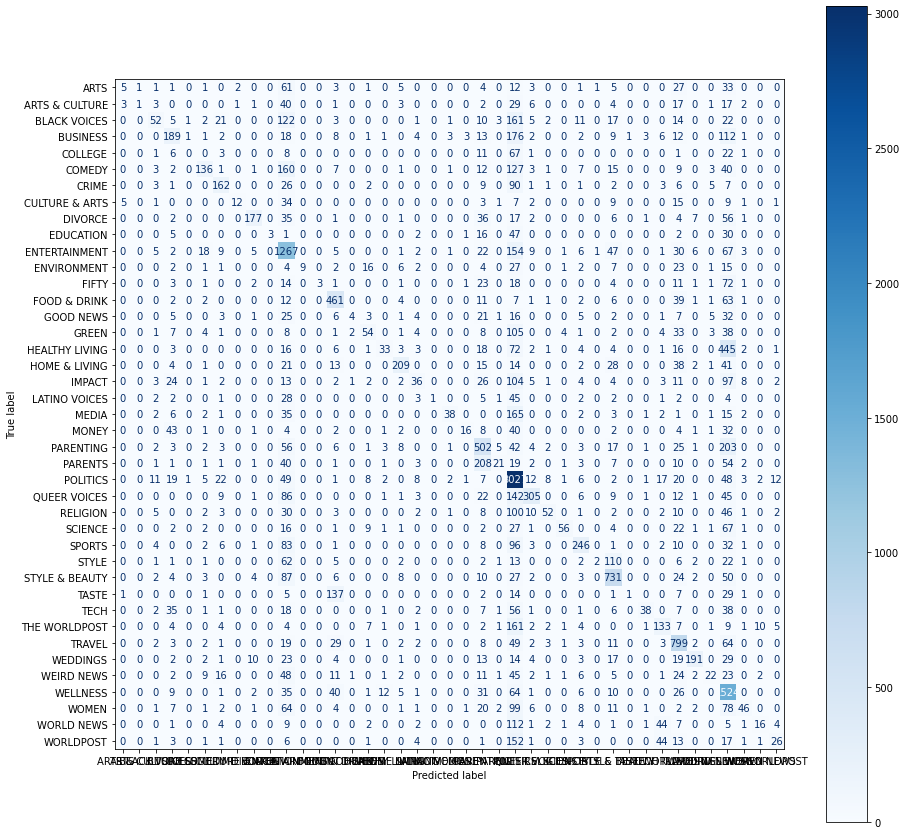

In [358]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)

In [359]:
print(classification_report(test.category, predicted_test))

                precision    recall  f1-score   support

          ARTS       0.36      0.03      0.06       167
ARTS & CULTURE       0.50      0.01      0.02       131
  BLACK VOICES       0.48      0.11      0.19       453
      BUSINESS       0.46      0.33      0.39       568
       COLLEGE       0.00      0.00      0.00       121
        COMEDY       0.66      0.26      0.37       529
         CRIME       0.57      0.51      0.54       319
CULTURE & ARTS       0.80      0.12      0.21       100
       DIVORCE       0.85      0.51      0.64       346
     EDUCATION       1.00      0.03      0.05       107
 ENTERTAINMENT       0.47      0.76      0.58      1662
   ENVIRONMENT       1.00      0.07      0.14       123
         FIFTY       1.00      0.02      0.04       157
  FOOD & DRINK       0.60      0.75      0.67       614
     GOOD NEWS       0.50      0.03      0.05       142
         GREEN       0.49      0.19      0.28       281
HEALTHY LIVING       0.57      0.05      0.10  

## Recortando categorias NB

Recortemos las categorias para incluir más del 50%. Inicialmente, combinemos la categoria "PARENTS" a "PARENTING"

In [360]:
df_liquid_text2.loc[df_liquid_text2['category']=='PARENTS','category'] = 'PARENTING'

Luego, el resto de categorias llevemoslas a una nueva categoria llamada "OTHER"

In [361]:
to_other = ['QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','SPORTS','BLACK VOICES','HOME & LIVING',
 'THE WORLDPOST','WEDDINGS','WOMEN','IMPACT','DIVORCE','CRIME','MEDIA','WEIRD NEWS','GREEN',
 'WORLDPOST','RELIGION','STYLE','SCIENCE','WORLD NEWS','TASTE','TECH','MONEY','ARTS','FIFTY',
 'GOOD NEWS','ARTS & CULTURE','ENVIRONMENT','COLLEGE','LATINO VOICES','CULTURE & ARTS','EDUCATION']
df_liquid_text2['category'] = df_liquid_text2.apply(lambda x: 'OTHER' if x['category'] in to_other else x['category'], axis = 1)

<AxesSubplot:>

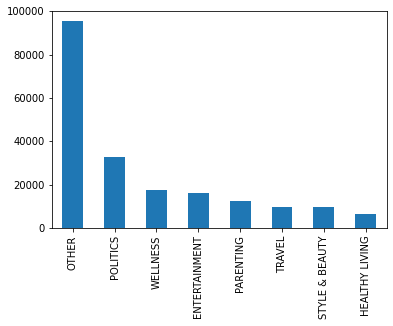

In [362]:
df_liquid_text2.category.value_counts().plot.bar()

In [363]:
train, test = train_test_split(df_liquid_text2, test_size=0.1, random_state=42, shuffle=True)
search = GridSearchCV(text_clf_CV, param_grid, n_jobs=2)
search.fit(train.text, train.category)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

KeyboardInterrupt: 

In [ ]:
descrete = 'tfidf__use_idf'
continuous = 'vect__max_features'
result_values = GridSearchResultToDF(search)    
PlotComparison(result_values, descrete, continuous)

In [ ]:
text_clf = search.best_estimator_.fit(train['text'], train.category)
predicted_test = text_clf.predict(test['text'])
np.mean(predicted_test == test.category)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
disp = plot_confusion_matrix(text_clf, test['text'], test.category,
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax = ax)